# A. Problem Statement
- Securing approval for a loan can be a time-consuming process, varying significantly for different purposes.
    - Approval for a personal loan may take 1-2 weeks, while the mortgage approval process can span 4-6 weeks.
- Our proposed solution aims provide users with a shorter and more efficient experience.
- The goal is to inform users about the likelihood of their application being accepted or rejected 
    - along with suggesting a suitable loan amount that stands a higher chance of approval.


# B. Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
raw_set = pd.read_csv('/Users/seangastinov/Downloads/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)

/var/folders/47/6csbx34d1dz8n9dk3xpsrs6r0000gp/T/ipykernel_19099/2959477168.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/47/6csbx34d1dz8n9dk3xpsrs6r0000gp/T/ipykernel_19099/2959477168.py:7: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_set = pd.read_csv('/Users/seangastinov/Downloads/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)


# C. Data Cleaning
## 1. Drop Unnecessary Variables
Drop columns from 'title' to the end to simplify user input.

In [3]:
start_index= raw_set.columns.get_loc('title')
acc_set = raw_set.iloc[:, :start_index]

acc_set = acc_set.drop(['member_id','funded_amnt_inv','installment','sub_grade','funded_amnt','id','url','desc','pymnt_plan','emp_title','issue_d','verification_status'],axis=1)

## 2. Dataset Overview

In [3]:
acc_set.head(100)

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Source Verified,Current,debt_consolidation
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase
...,...,...,...,...,...,...,...,...,...,...
95,8000.0,36 months,10.78,B,< 1 year,MORTGAGE,45000.0,Not Verified,Fully Paid,debt_consolidation
96,12000.0,36 months,10.78,B,3 years,RENT,40000.0,Not Verified,Fully Paid,credit_card
97,18000.0,36 months,7.49,A,5 years,MORTGAGE,75000.0,Not Verified,Fully Paid,debt_consolidation
98,3600.0,36 months,11.48,B,< 1 year,MORTGAGE,85000.0,Source Verified,Fully Paid,debt_consolidation


In [4]:
acc_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   loan_amnt            float64
 1   term                 object 
 2   int_rate             float64
 3   grade                object 
 4   emp_length           object 
 5   home_ownership       object 
 6   annual_inc           float64
 7   verification_status  object 
 8   loan_status          object 
 9   purpose              object 
dtypes: float64(3), object(7)
memory usage: 172.5+ MB


## 3. Missing Values

In [4]:
# Check for missing values
acc_set.isnull().sum()

loan_amnt             33
term                  33
int_rate              33
grade                 33
emp_length        146940
home_ownership        33
annual_inc            37
loan_status           33
purpose               33
dtype: int64

Missing Values By Percentage

In [5]:
missing_percentage = (acc_set.isnull().sum() / len(acc_set)) * 100
# Create DF to display the results
missing_data = pd.DataFrame({
    'Variable': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})
# Sort the DF by missing percentage
missing_data = missing_data.sort_values(by='Missing Percentage', ascending=False)
print(missing_data)

         Variable  Missing Percentage
4      emp_length            6.499754
6      annual_inc            0.001637
0       loan_amnt            0.001460
2        int_rate            0.001460
1            term            0.001460
3           grade            0.001460
5  home_ownership            0.001460
7     loan_status            0.001460
8         purpose            0.001460


Drop rows with missing value since the data is large enough and the percentage is small

In [6]:
# Becomes 2113757 entries
acc_set = acc_set.dropna()

## 4. Check for Outliers and Skewness

### I. Loan Amount

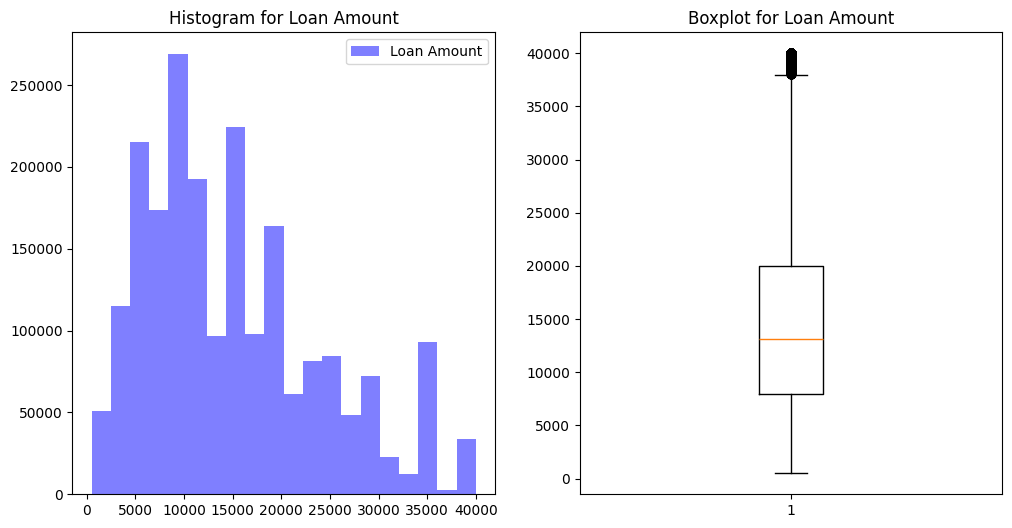

In [7]:
plt.figure(figsize=(12, 6))

# Plotting histogram
plt.subplot(1, 2, 1)
plt.hist(acc_set['loan_amnt'], bins=20, alpha=0.5, color='b', label='Loan Amount')
plt.title('Histogram for Loan Amount')
plt.legend()

# Plotting boxplot
plt.subplot(1, 2, 2)
plt.title('Boxplot for Loan Amount')
plt.boxplot(acc_set['loan_amnt'])

plt.show()

The distribution looks skewed and have outliers

In [ ]:
# Remove Outliers
Q1 = acc_set['loan_amnt'].quantile(0.25)
Q3 = acc_set['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1
acc_set = acc_set[~((acc_set['loan_amnt'] < (Q1 - 1.5 * IQR)) | (acc_set['loan_amnt'] > (Q3 + 1.5 * IQR)))]

### Skewness Check
Loan Amount is still moderately skewed (coefficient of skewness is between 0.5 and 1)

In [ ]:
print(acc_set["loan_amnt"].skew())

0.6741520956000117


Cubic Root Transformation (To Reduce Skewness)
The distribution is approximately normal (coefficient of skewness is between -0.5 and 0.5)


In [10]:
acc_set['loan_amnt']= np.cbrt(acc_set['loan_amnt'])

# Remove outliers after transformation
Q1 = acc_set['loan_amnt'].quantile(0.25)
Q3 = acc_set['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1
acc_set = acc_set[~((acc_set['loan_amnt'] < (Q1 - 1.5 * IQR)) | (acc_set['loan_amnt'] > (Q3 + 1.5 * IQR)))]

acc_set['loan_amnt'].skew()

-0.13976335339326834

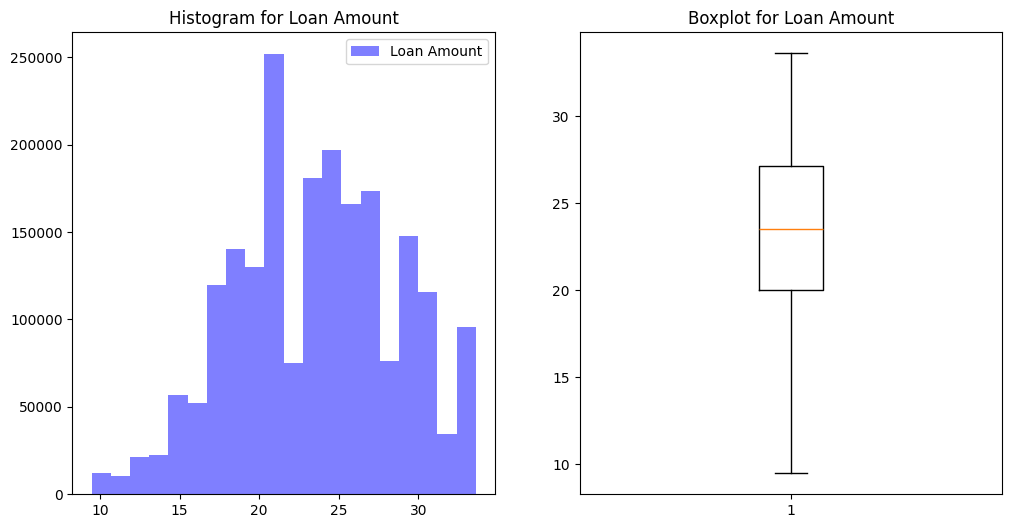

In [11]:
plt.figure(figsize=(12, 6))

# Plotting histogram
plt.subplot(1, 2, 1)
plt.hist(acc_set['loan_amnt'], bins=20, alpha=0.5, color='b', label='Loan Amount')
plt.title('Histogram for Loan Amount')
plt.legend()

# Plotting boxplot
plt.subplot(1, 2, 2)
plt.title('Boxplot for Loan Amount')
plt.boxplot(acc_set['loan_amnt'])

plt.show()

### II. Interest Rate 

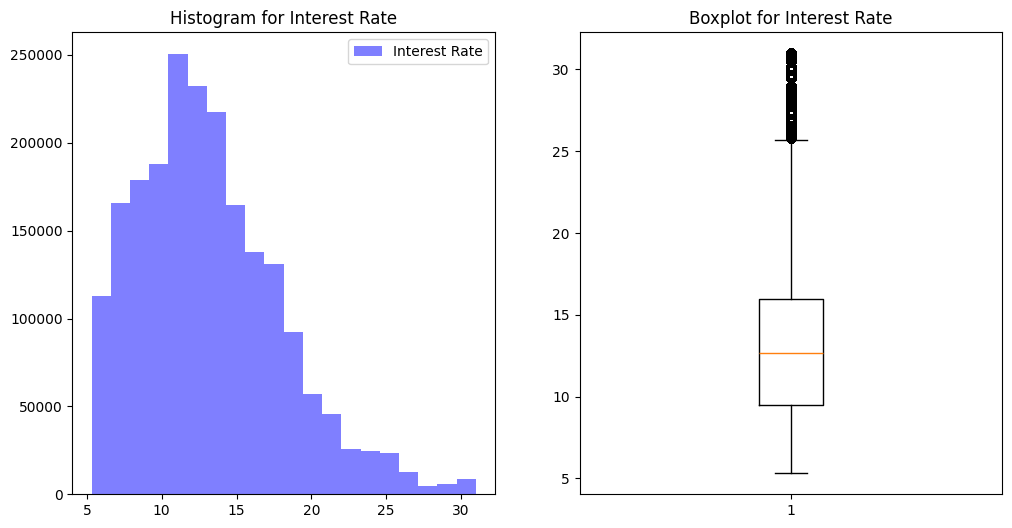

In [12]:
plt.figure(figsize=(12, 6))

# Plotting histogram
plt.subplot(1, 2, 1)
plt.hist(acc_set['int_rate'], bins=20, alpha=0.5, color='b', label='Interest Rate')
plt.title('Histogram for Interest Rate')
plt.legend()

# Plotting boxplot
plt.subplot(1, 2, 2)
plt.boxplot(acc_set['int_rate'])
plt.title('Boxplot for Interest Rate')


plt.show()

The distribution looks skewed and have outliers 

Remove Outliers

In [13]:
#REMOVE OUTLIERS
Q1 = acc_set['int_rate'].quantile(0.25)
Q3 = acc_set['int_rate'].quantile(0.75)
IQR = Q3 - Q1
acc_set = acc_set[~((acc_set['int_rate'] < (Q1 - 1.5 * IQR)) | (acc_set['int_rate'] > (Q3 + 1.5 * IQR)))]

### SKEWNESS RECHECK
int_rate's distribution is approximately normal (coefficient of skewness is between -0.5 and 0.5)

In [ ]:
print(acc_set["int_rate"].skew())

0.47697038024960914


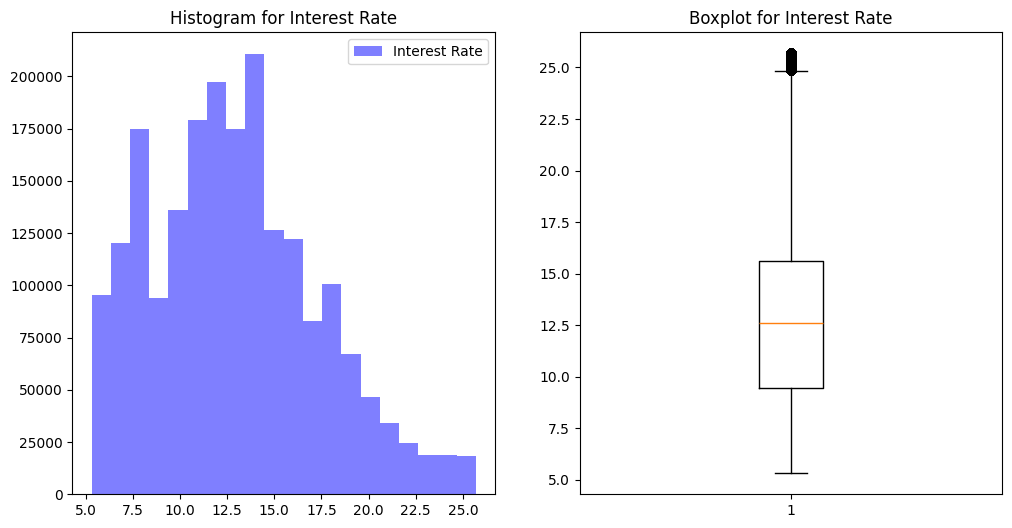

In [18]:
plt.figure(figsize=(12, 6))

# Plotting histogram
plt.subplot(1, 2, 1)
plt.hist(acc_set['int_rate'], bins=20, alpha=0.5, color='b', label='Interest Rate')
plt.title('Histogram for Interest Rate')
plt.legend()

# Plotting boxplot
plt.subplot(1, 2, 2)
plt.boxplot(acc_set['int_rate'])
plt.title('Boxplot for Interest Rate')


plt.show()

### III. Annual Income

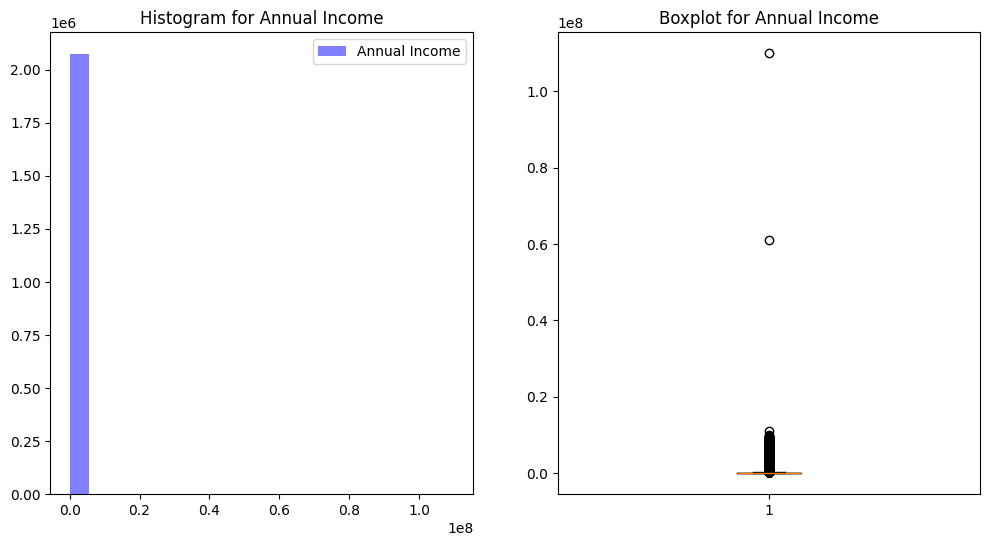

In [13]:
plt.figure(figsize=(12, 6))

# Plotting histogram
plt.subplot(1, 2, 1)
plt.hist(acc_set['annual_inc'], bins=20, alpha=0.5, color='b', label='Annual Income')
plt.title('Histogram for Annual Income')
plt.legend()

# Plotting boxplot
plt.subplot(1, 2, 2)
plt.boxplot(acc_set['annual_inc'])
plt.title('Boxplot for Annual Income')


plt.show()

The distribution looks skewed and have outliers 

In [19]:
#REMOVE OUTLIERS
Q1 = acc_set['annual_inc'].quantile(0.25)
Q3 = acc_set['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
acc_set = acc_set[~((acc_set['annual_inc'] < (Q1 - 1.5 * IQR)) | (acc_set['annual_inc'] > (Q3 + 1.5 * IQR)))]

#### SKEWNESS RECHECK
annual_inc is still moderately skewed (coefficient of skewness is between 0.5 and 1)

In [21]:
print(acc_set["annual_inc"].skew())

0.7622968531008805


In [22]:
acc_set['annual_inc']= np.cbrt(acc_set['annual_inc'])

# Remove outliers after transformation
Q1 = acc_set['annual_inc'].quantile(0.25)
Q3 = acc_set['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
acc_set = acc_set[~((acc_set['annual_inc'] < (Q1 - 1.5 * IQR)) | (acc_set['annual_inc'] > (Q3 + 1.5 * IQR)))]

acc_set['annual_inc'].skew()

0.12694192961901365

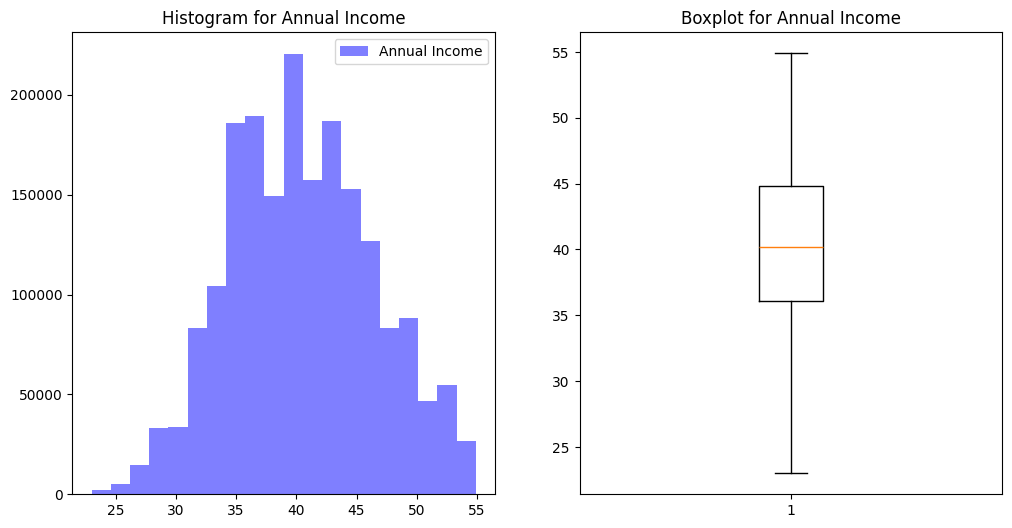

In [23]:
plt.figure(figsize=(12, 6))

# Plotting histogram
plt.subplot(1, 2, 1)
plt.hist(acc_set['annual_inc'], bins=20, alpha=0.5, color='b', label='Annual Income')
plt.title('Histogram for Annual Income')
plt.legend()

# Plotting boxplot
plt.subplot(1, 2, 2)
plt.boxplot(acc_set['annual_inc'])
plt.title('Boxplot for Annual Income')


plt.show()

## 5. Showing Categories in Loan Status
We have decided to use two categories, 'Fully Paid' and 'Charged Off,' to determine whether the user's proposed loan amount is approved or not.

'Charged Off' means that the applicant is unable to pay off the loan.

In [25]:
category_counts = acc_set['loan_status'].value_counts()
print(category_counts)

loan_status
Fully Paid                                             957554
Current                                                730058
Charged Off                                            228796
Late (31-120 days)                                      17121
In Grace Period                                          6747
Late (16-30 days)                                        3340
Does not meet the credit policy. Status:Fully Paid       1820
Does not meet the credit policy. Status:Charged Off       686
Default                                                    30
Name: count, dtype: int64


## 6. Filter Categories

In [28]:
filtered_acc_set = acc_set[acc_set['loan_status'].isin(['Fully Paid', 'Charged Off'])]
filtered_acc_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1186350 entries, 0 to 2260697
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   loan_amnt       1186350 non-null  float64
 1   term            1186350 non-null  object 
 2   int_rate        1186350 non-null  float64
 3   grade           1186350 non-null  object 
 4   emp_length      1186350 non-null  object 
 5   home_ownership  1186350 non-null  object 
 6   annual_inc      1186350 non-null  float64
 7   loan_status     1186350 non-null  object 
 8   purpose         1186350 non-null  object 
dtypes: float64(3), object(6)
memory usage: 90.5+ MB


## 7. Removing Outliers per Categories
Boxplots show some outliers

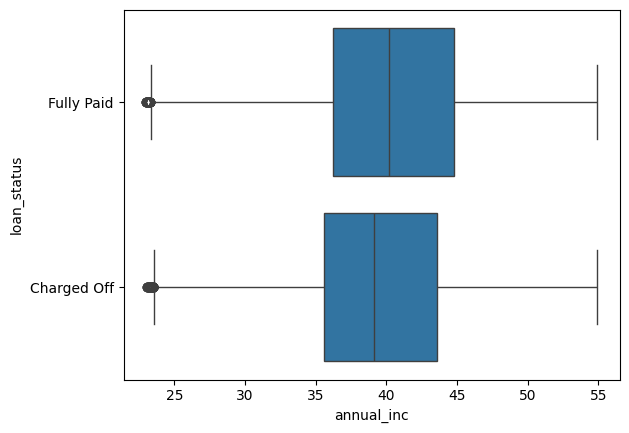

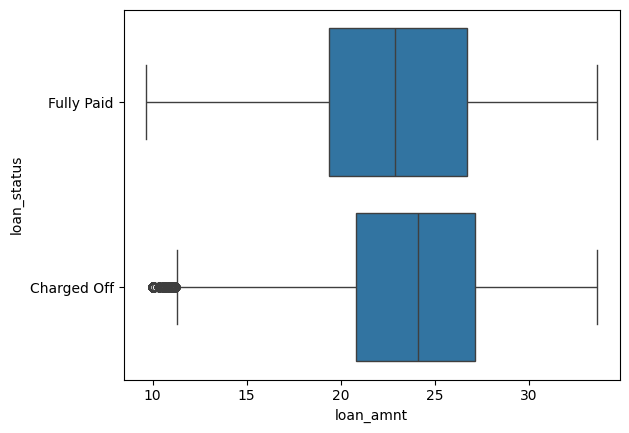

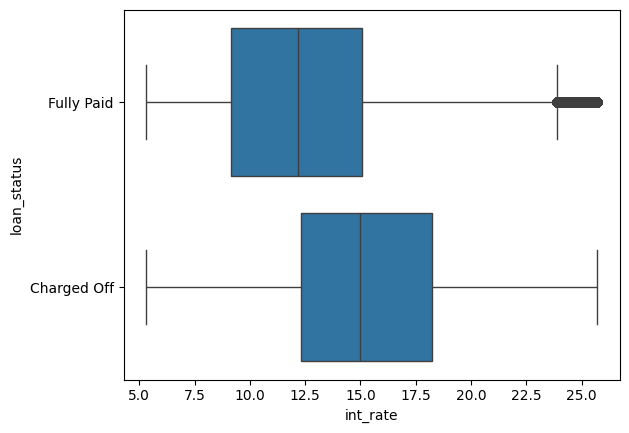

In [29]:
sns.boxplot(x='annual_inc', y='loan_status', data=filtered_acc_set)
plt.show()
sns.boxplot(x='loan_amnt', y='loan_status', data=filtered_acc_set)
plt.show()
sns.boxplot(x='int_rate', y='loan_status', data=filtered_acc_set)
plt.show()


### Separate into 2 Dataset by Loan Status Category

In [30]:
filtered_acc_set_paid = acc_set[acc_set['loan_status'].isin(['Fully Paid'])]
filtered_acc_set_charged = acc_set[acc_set['loan_status'].isin(['Charged Off'])]


In [31]:
Q1 = filtered_acc_set_paid['annual_inc'].quantile(0.25)
Q3 = filtered_acc_set_paid['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
filtered_acc_set_paid = filtered_acc_set_paid[~((filtered_acc_set_paid['annual_inc'] < (Q1 - 1.5 * IQR)) | (filtered_acc_set_paid['annual_inc'] > (Q3 + 1.5 * IQR)))]

In [32]:
Q1 = filtered_acc_set_paid['loan_amnt'].quantile(0.25)
Q3 = filtered_acc_set_paid['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1
filtered_acc_set_paid = filtered_acc_set_paid[~((filtered_acc_set_paid['loan_amnt'] < (Q1 - 1.5 * IQR)) | (filtered_acc_set_paid['loan_amnt'] > (Q3 + 1.5 * IQR)))]

In [33]:
Q1 = filtered_acc_set_paid['int_rate'].quantile(0.25)
Q3 = filtered_acc_set_paid['int_rate'].quantile(0.75)
IQR = Q3 - Q1
filtered_acc_set_paid = filtered_acc_set_paid[~((filtered_acc_set_paid['int_rate'] < (Q1 - 1.5 * IQR)) | (filtered_acc_set_paid['int_rate'] > (Q3 + 1.5 * IQR)))]

In [35]:
Q1 = filtered_acc_set_charged['annual_inc'].quantile(0.25)
Q3 = filtered_acc_set_charged['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
filtered_acc_set_charged = filtered_acc_set_charged[~((filtered_acc_set_charged['annual_inc'] < (Q1 - 1.5 * IQR)) | (filtered_acc_set_charged['annual_inc'] > (Q3 + 1.5 * IQR)))]

In [36]:
Q1 = filtered_acc_set_charged['loan_amnt'].quantile(0.25)
Q3 = filtered_acc_set_charged['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1
filtered_acc_set_charged = filtered_acc_set_charged[~((filtered_acc_set_charged['loan_amnt'] < (Q1 - 1.5 * IQR)) | (filtered_acc_set_charged['loan_amnt'] > (Q3 + 1.5 * IQR)))]

In [37]:
Q1 = filtered_acc_set_charged['int_rate'].quantile(0.25)
Q3 = filtered_acc_set_charged['int_rate'].quantile(0.75)
IQR = Q3 - Q1
filtered_acc_set_charged = filtered_acc_set_charged[~((filtered_acc_set_charged['int_rate'] < (Q1 - 1.5 * IQR)) | (filtered_acc_set_charged['int_rate'] > (Q3 + 1.5 * IQR)))]

In [ ]:
filtered_acc_set = pd.concat([filtered_acc_set_paid, filtered_acc_set_charged])

# Relation Between Categorical Variable vs Numerical Variable

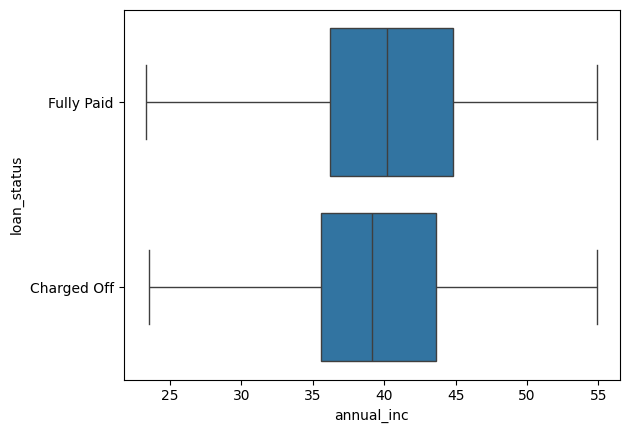

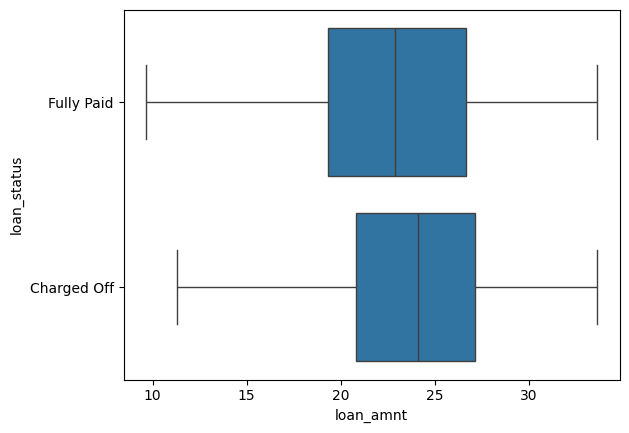

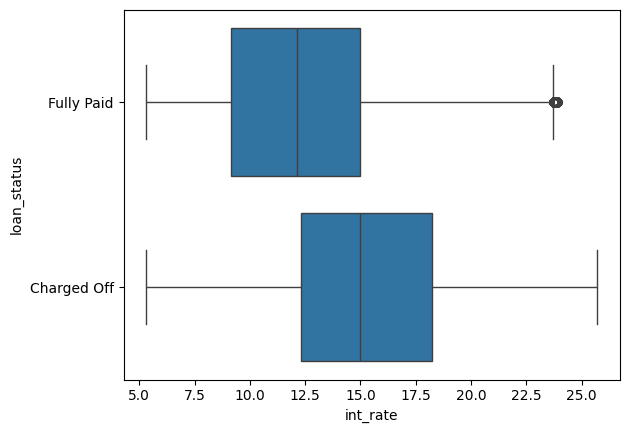

In [39]:
sns.boxplot(x='annual_inc', y='loan_status', data=filtered_acc_set)
plt.show()
sns.boxplot(x='loan_amnt', y='loan_status', data=filtered_acc_set)
plt.show()
sns.boxplot(x='int_rate', y='loan_status', data=filtered_acc_set)
plt.show()


### ANOVA TEST

In [46]:
result = stats.f_oneway(filtered_acc_set_paid['annual_inc'] , filtered_acc_set_charged['annual_inc'])

print(f'F-statistic: {result.statistic:.6f}')
print(f'P-value: {result.pvalue:.15f}')

# p-value is less than 0.05, so we reject the null hypothesis and conclude that the means of annual income
# are significantly different between the people who charged off and the people who fully paid

F-statistic: 3382.275989
P-value: 0.000000000000000


In [47]:
result = stats.f_oneway(filtered_acc_set_paid['loan_amnt'], filtered_acc_set_charged['loan_amnt'])

print(f'F-statistic: {result.statistic:.6f}')
print(f'P-value: {result.pvalue:.15f}')

# p-value is less than 0.05, so we reject the null hypothesis and conclude that the means of loan amount 
# are significantly different between the people who charged off and the people who fully paid

F-statistic: 8681.277610
P-value: 0.000000000000000


In [48]:
result = stats.f_oneway(filtered_acc_set_paid['int_rate'] , filtered_acc_set_charged['int_rate'])

print(f'F-statistic: {result.statistic:.6f}')
print(f'P-value: {result.pvalue:.15f}')

# p-value is less than 0.05, so we reject the null hypothesis and conclude that the means of interest rate
# are significantly different between the people who charged off and the people who fully paid

F-statistic: 93951.231452
P-value: 0.000000000000000


### Conclusion
- Based on the ANOVA test, every p-value is very small, indicating a rejection of the null hypothesis. This suggests that the mean of the respective variable differs between the people who charged off and the people who fully paid

- Based on observation from Boxplot:
    - People who fully paid have a higher annual income compared to those who charged off
    - People who fully paid have a lower loan amount compared to those who charged off
    - People who fully paid have a lower interest rate compared to those who charged off

# Relation Between Categorical Variable vs Categorical Variable

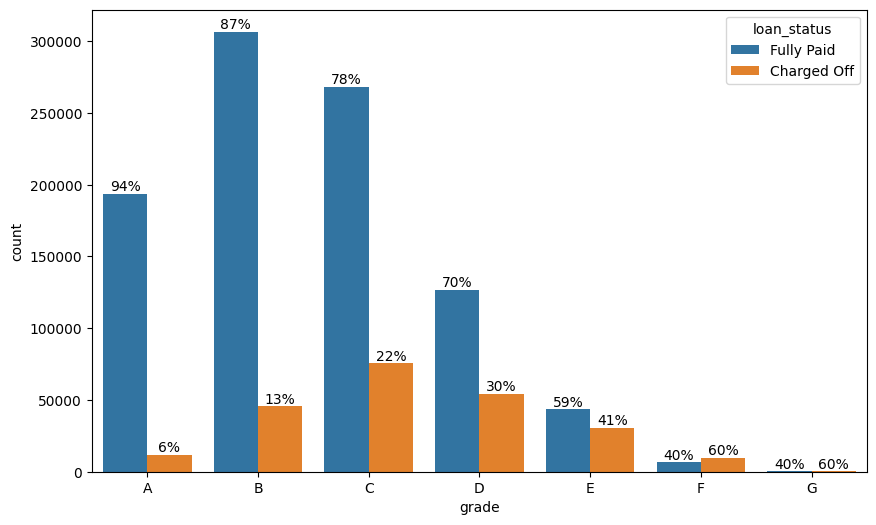

In [49]:

def barPerc(df, xVar, ax):
    # 1. how many X categories
    ##   check for NaN and remove
    numX = len([x for x in df[xVar].unique() if x == x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars = bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            percentage = bar.get_height() / total
            # Check if the percentage is greater than 0 before adding the label
            if percentage > 0:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height(),
                        f'{percentage:.0%}',
                        ha="center", va="bottom")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='grade',hue="loan_status", data=filtered_acc_set, order=sorted(filtered_acc_set['grade'].unique().tolist()))

barPerc(filtered_acc_set,'grade',ax)

- This shows that the Credit Grade significantly affects the Loan Status, as indicated by the varying proportions.
- Generally, individuals with higher Credit Grades (e.g., A with 94%/6%) have a greater proportion of fully paid loans compared to those with lower Credit Grades (e.g., G with 40%/60%).

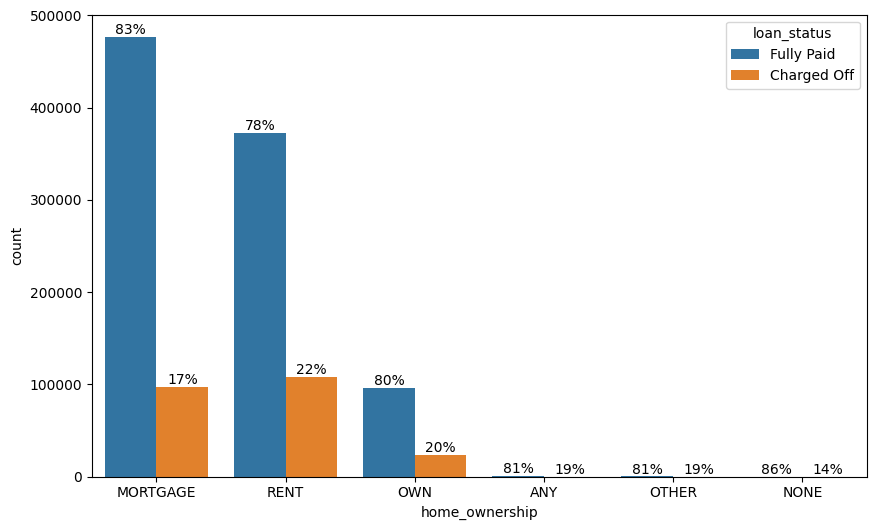

In [50]:
def barPerc(df, xVar, ax):
    numX = len([x for x in df[xVar].unique() if x == x])
    bars = ax.patches
    for ind in range(numX):
        hueBars = bars[ind:][::numX]
        total = sum([x.get_height() for x in hueBars])
        for bar in hueBars:
            percentage = bar.get_height() / total
            if percentage > 0:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height(),
                        f'{percentage:.0%}',
                        ha="center", va="bottom")
                
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='home_ownership',hue="loan_status", data=filtered_acc_set)
barPerc(filtered_acc_set, 'home_ownership', ax)

- Based on the observation, Home Ownership does not appear to be a significant factor influencing Loan Status.
- As evidenced by each category of Home Ownership having a proportion of approximately 80%/20%.

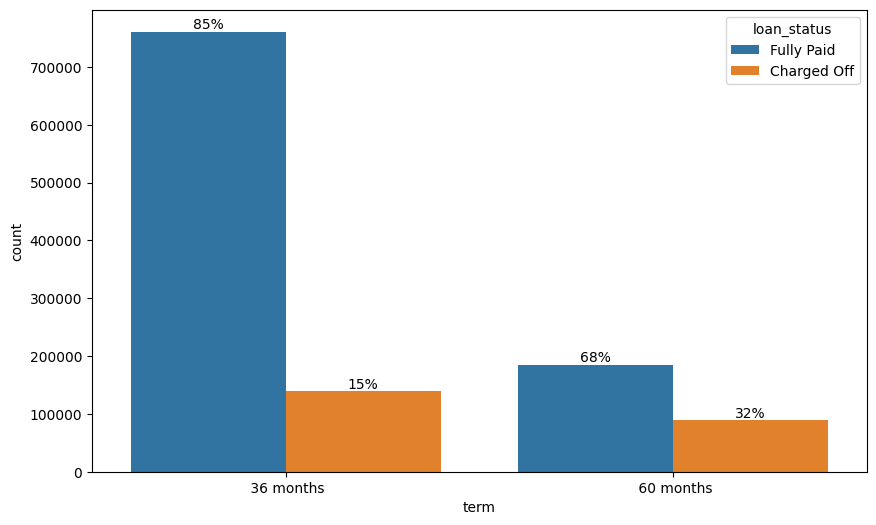

In [51]:
def barPerc(df, xVar, ax):
    numX = len([x for x in df[xVar].unique() if x == x])
    bars = ax.patches
    for ind in range(numX):
        hueBars = bars[ind:][::numX]
        total = sum([x.get_height() for x in hueBars])
        for bar in hueBars:
            percentage = bar.get_height() / total
            if percentage > 0:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height(),
                        f'{percentage:.0%}',
                        ha="center", va="bottom")
                
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='term',hue="loan_status", data=filtered_acc_set)
barPerc(filtered_acc_set, 'term', ax)

- This shows that the Loan Term significantly influences the Loan Status, as indicated by the varying proportions.
- Generally, individuals with a 36-month term (e.g., 85%/15%) have a higher proportion of fully paid loans compared to those with a 60-month term (e.g., 68%/32%).




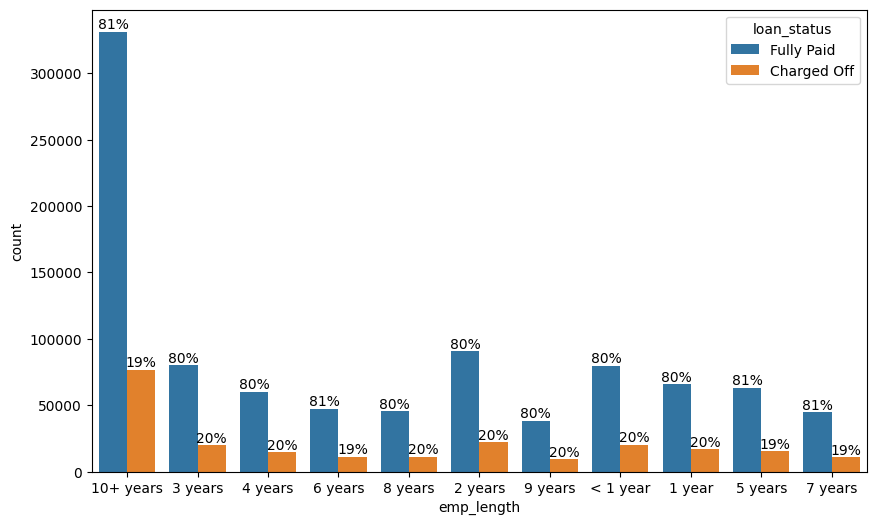

In [52]:
def barPerc(df, xVar, ax):
    numX = len([x for x in df[xVar].unique() if x == x])
    bars = ax.patches
    for ind in range(numX):
        hueBars = bars[ind:][::numX]
        total = sum([x.get_height() for x in hueBars])
        for bar in hueBars:
            percentage = bar.get_height() / total
            if percentage > 0:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height(),
                        f'{percentage:.0%}',
                        ha="center", va="bottom")
                
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='emp_length',hue="loan_status", data=filtered_acc_set)
barPerc(filtered_acc_set, 'emp_length', ax)

- Based on the observation, Employment Length does not appear to be a significant factor influencing Loan Status.
- As evidenced by each category of Employment Length having a proportion of approximately 80%/20%.

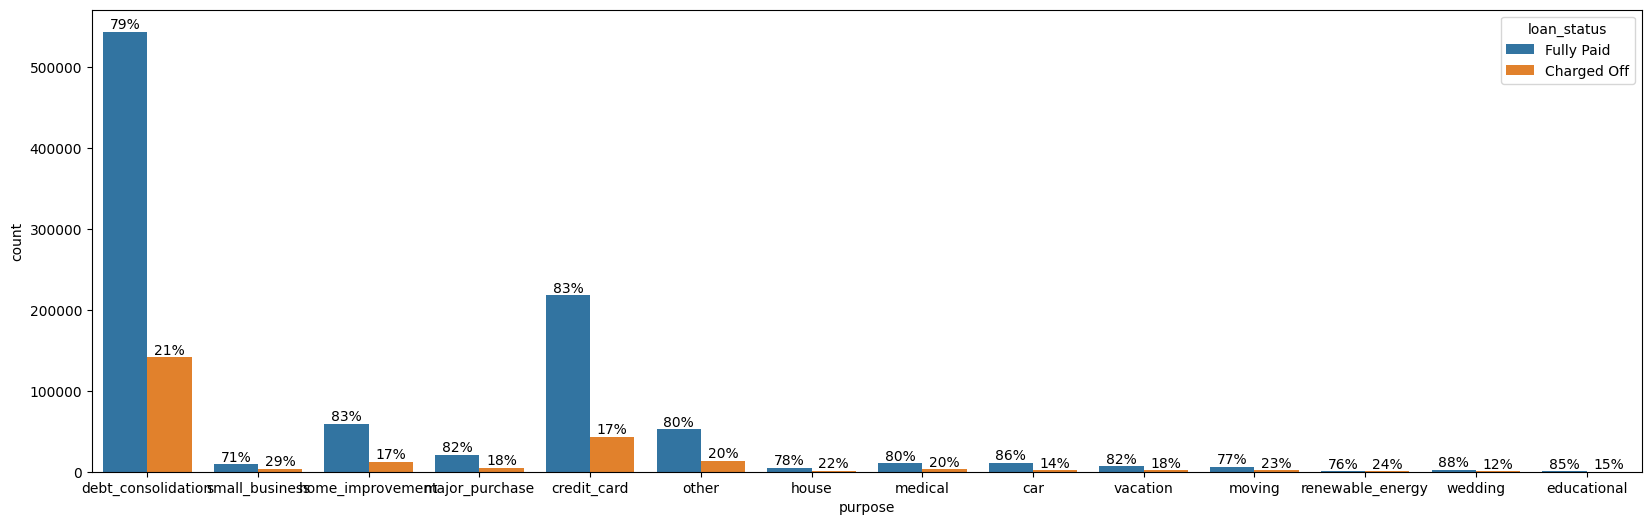

In [53]:
def barPerc(df, xVar, ax):
    numX = len([x for x in df[xVar].unique() if x == x])
    bars = ax.patches
    for ind in range(numX):
        hueBars = bars[ind:][::numX]
        total = sum([x.get_height() for x in hueBars])
        for bar in hueBars:
            percentage = bar.get_height() / total
            if percentage > 0:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height(),
                        f'{percentage:.0%}',
                        ha="center", va="bottom")
                
plt.figure(figsize=(20, 6))
ax = sns.countplot(x='purpose',hue="loan_status", data=filtered_acc_set)
barPerc(filtered_acc_set, 'purpose', ax)

- Generally, the Purpose of the loan is somewhat significant in relation to Loan Status. 
- However, its influence is not as strong when compared to Grade and Term

### Conclusion
- We consider Grade, Term, and Purpose as significant variables for predicting loan status.
- We opt to exclude home ownership and employment length as they do not appear to be significant predictors of loan status.

# CORRELATION IN NUMERICAL VARIABLE

<Axes: >

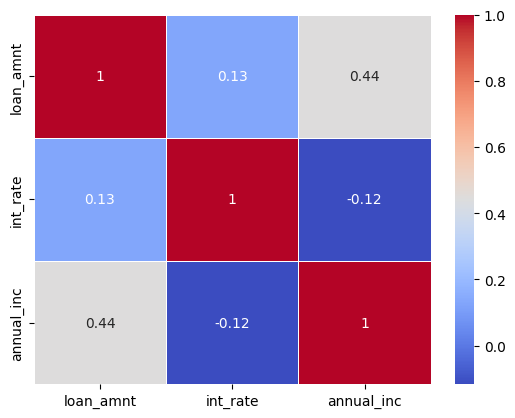

In [54]:
sns.heatmap(filtered_acc_set.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', linewidths=0.5 )

### By Paid Off Category

<Axes: >

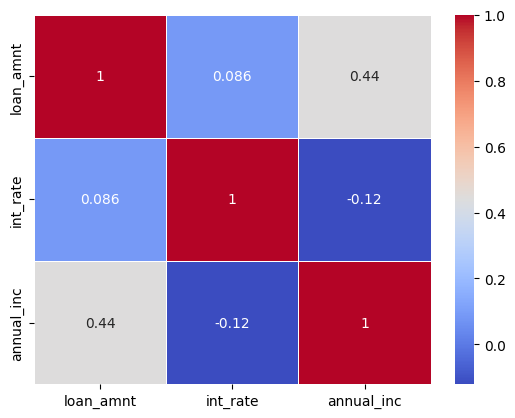

In [55]:
sns.heatmap(filtered_acc_set_paid.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', linewidths=0.5 )

### By Charged Off Category

<Axes: >

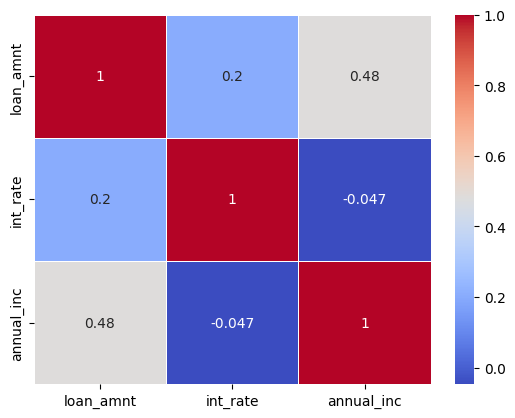

In [56]:
sns.heatmap(filtered_acc_set_charged.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', linewidths=0.5, )

#### The highest correlation is between loan amount and annual income with coefficient 0.44/0.44/0.48 (Everything/Paid/Charged) (Fairly correlated)